- 用overfit後調好的模型再行訓練
- 增加搖動影像
- 吃15000 的GKF 1 - 4
- 改過data generator
- 改過load npz
- 純吃R02

## 訓練模型

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint

import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import time
from scipy.ndimage.interpolation import shift,rotate,zoom

In [2]:
def chaos_aug64_simple(img_npz, shift_random=0):
    cond_2 = random.randint(0, 31)
        
    if cond_2 == 0:
        img_npz = shift(img_npz, [1, 0, 0], cval=0)  # 往下
    if cond_2 == 1:
        img_npz = shift(img_npz, [-1, 0, 0], cval=0)  # 往上
    if cond_2 == 2:
        img_npz = shift(img_npz, [0, 1, 0], cval=0)  # 往右
    if cond_2 == 3:
        img_npz = shift(img_npz, [0, -1, 0], cval=0)  # 往左
    if cond_2 == 4:
        img_npz = shift(img_npz, [2, 0, 0], cval=0)  # 往下
    if cond_2 == 5:
        img_npz = shift(img_npz, [-2, 0, 0], cval=0)  # 往上
    if cond_2 == 6:
        img_npz = shift(img_npz, [0, 2, 0], cval=0)  # 往右
    if cond_2 == 7:
        img_npz = shift(img_npz, [0, -2, 0], cval=0)  # 往左
    
    return img_npz

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def load_npz(img):
    img_array = np.load(img)['arr_0'].T.reshape((128, 128, 64))       
#     img_array = np.where(img_array < 4096, img_array, 4096)
#     img_array = np.where(img_array > -1024, img_array, -1024)
    return (img_array - img_array.min()) / (img_array.max() - img_array.min())

def load_npz_img_chaos(img):
    #return chaos_aug64(load_npz(img), max_shift_pixel=5, shift_random=1)
    return chaos_aug64_simple(load_npz(img))

class DataGenerator(tf.keras.utils.Sequence):
    """
    Keras Sequence object to train a model on larger-than-memory data.
    """

    def __init__(self, df, data_path, batch_size, dim=(128, 128, 64), n_channels=1, shuffle=True, concat=False, chaos=False):
        "Initialization"
        self.df = df
        self.dim = dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.concat = concat
        self.chaos = chaos
        self.df['name'] = self.df['GKF'] + '/' + \
            self.df['case'] + '/' + self.df['final_key'] + '.npz'
        self.img_list = self.df['name'].apply(
            lambda x: os.path.join(data_path, x)).tolist()
        self.y = self.df['label'].replace(['Y', 'N'], [1, 0])
        self.incidies = np.arange(self.df.shape[0])
        self.on_epoch_end()

    def __len__(self):
        'Calculate the number of iterations of each epoch'
        return int(math.ceil(len(self.df) / float(self.batch_size)))

    def get_batch_image_features(self, idx):
        'Fetch a batch of inputs'
        ics = self.incidies[idx * self.batch_size: (1 + idx) * self.batch_size]
        
        img_shuffle_list = [self.img_list[loc] for loc in [id for id in ics]]
        
#         self.img_list[self.incidies[idx * self.batch_size: (1 + idx) * self.batch_size]]]
#         self.img_list[self.incidies[idx * self.batch_size: (1 + idx) * self.batch_size]]]
        if self.chaos:
            return np.array([load_npz_img_chaos(img) for img in img_shuffle_list])
        else:
            return np.array([load_npz_img(img) for img in img_shuffle_list])

    def __getitem__(self, idx):
        'Generate one batch of data'
        ics = self.incidies[idx * self.batch_size: (1 + idx) * self.batch_size]

        if self.concat:
            batch_x = [self.get_batch_image_features(idx),
                       self.df.filter(['SEX', 'AGE']).loc[ics].values]
        else:
            batch_x = self.get_batch_image_features(idx)
            
        batch_y = self.y[ics]
        return batch_x, np.array(batch_y)

    def on_epoch_end(self):
        'Shuffles indexes after each epoch if in training mode'
        np.random.shuffle(self.incidies)



In [17]:
def tf_learning_model(img_size=(128, 128, 64)):
    'my transfer learning model'
    
    input_img = Input(shape=img_size)
    
    x = Conv2D(32, kernel_size=(3, 3), activation='relu',
               padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv2D(16, kernel_size=(3, 3), activation='relu',
               padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Conv2D(3, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    # we add dense layers so that the model can learn more complex functions and classify for better results.
    # final layer with softmax activation for N classes
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    preds = Dense(1, activation='sigmoid')(x)  
    
    tf_model = tf.keras.Model(inputs=input_img, outputs=preds, name='tranfer_model')

    return tf_model

# read data

In [4]:
# 訓練次數
# epochs = 5
# 資料mapping表
df_tmp = pd.read_csv('./tf_init_0810.csv')
df_tmp

,GKF,case,final_key,label,maximum,minimum
0,test,case,P1887_S01_R01_Y_S1,Y,1598,-2048
1,test,case,P1887_S01_R02_Y_S1,Y,1645,-2048
2,train,case,P2310_S01_R03_Y_S1,Y,1471,-2048
3,train,case,P2310_S01_R02_Y_S1,Y,1504,-2048
4,train,case,P2310_S01_R01_Y_S1,Y,1489,-2048
...,...,...,...,...,...,...
15120,train,control,P2506_S01_R02_N_S1,N,1543,-3024
15121,train,control,P2506_S01_R03_N_S1,N,1128,-3024
15122,train,control,P6075_S01_R02_N_S1,N,1581,-1024
15123,train,control,P6075_S01_R01_N_S1,N,1574,-1024


In [5]:
df_tmp['study'] = df_tmp.final_key.str.split('_', expand=True)[1]
df_tmp['series'] = df_tmp.final_key.str.split('_', expand=True)[2]
df_tmp['PATIENT'] = df_tmp.final_key.str.split('_', expand=True)[0]
df_tmp['PATIENT'] = df_tmp.PATIENT.str.split('P',expand=True)[1]
# df_tmp['STUDY'] = df_tmp.final_key.str.split('_', expand=True)[1]
# df_tmp['STUDY'] = df_tmp.STUDY.str.split('S',expand=True)[1]
df_tmp['KEY_ID'] = 'psuedoID_' + df_tmp.PATIENT + '_S0' + df_tmp.study
df_tmp

,GKF,case,final_key,label,maximum,minimum,study,series,PATIENT,KEY_ID
0,test,case,P1887_S01_R01_Y_S1,Y,1598,-2048,S01,R01,1887,psuedoID_1887_S0S01
1,test,case,P1887_S01_R02_Y_S1,Y,1645,-2048,S01,R02,1887,psuedoID_1887_S0S01
2,train,case,P2310_S01_R03_Y_S1,Y,1471,-2048,S01,R03,2310,psuedoID_2310_S0S01
3,train,case,P2310_S01_R02_Y_S1,Y,1504,-2048,S01,R02,2310,psuedoID_2310_S0S01
4,train,case,P2310_S01_R01_Y_S1,Y,1489,-2048,S01,R01,2310,psuedoID_2310_S0S01
...,...,...,...,...,...,...,...,...,...,...
15120,train,control,P2506_S01_R02_N_S1,N,1543,-3024,S01,R02,2506,psuedoID_2506_S0S01
15121,train,control,P2506_S01_R03_N_S1,N,1128,-3024,S01,R03,2506,psuedoID_2506_S0S01
15122,train,control,P6075_S01_R02_N_S1,N,1581,-1024,S01,R02,6075,psuedoID_6075_S0S01
15123,train,control,P6075_S01_R01_N_S1,N,1574,-1024,S01,R01,6075,psuedoID_6075_S0S01


In [6]:
#df_train = df_tmp.loc[df_tmp.series == 'R01'].sample(5304, random_state=123).reset_index(drop=True)
df_train = df_tmp.loc[df_tmp.GKF=='train'].reset_index(drop=True)
df_train = df_train.loc[df_train.series=='R02'].reset_index(drop=True)
df_train = df_train.sample(df_train.shape[0], random_state=914).reset_index(drop=True)
df_train

,GKF,case,final_key,label,maximum,minimum,study,series,PATIENT,KEY_ID
0,train,control,P5769_S01_R02_N_S1,N,1580,-3024,S01,R02,5769,psuedoID_5769_S0S01
1,train,case,P0229_S01_R02_Y_S1,Y,1539,-3024,S01,R02,0229,psuedoID_0229_S0S01
2,train,control,P6160_S01_R02_N_S1,N,964,-3024,S01,R02,6160,psuedoID_6160_S0S01
3,train,control,P4631_S01_R02_N_S1,N,1456,-3024,S01,R02,4631,psuedoID_4631_S0S01
4,train,control,P5976_S01_R02_N_S1,N,1531,-2048,S01,R02,5976,psuedoID_5976_S0S01
...,...,...,...,...,...,...,...,...,...,...
4074,train,control,P4140_S01_R02_N_S1,N,2756,-1024,S01,R02,4140,psuedoID_4140_S0S01
4075,train,case,P1005_S01_R02_Y_S1,Y,8858,-2048,S01,R02,1005,psuedoID_1005_S0S01
4076,train,control,P3123_S01_R02_N_S1,N,1621,-1024,S01,R02,3123,psuedoID_3123_S0S01
4077,train,control,P4454_S01_R02_N_S1,N,3202,-2048,S01,R02,4454,psuedoID_4454_S0S01


In [7]:
#df_test = df_tmp.loc[(df_tmp.GKF == 'test') & (df_tmp.series == 'R02')].sample(1027, random_state=123).reset_index(drop=True)
df_test = df_tmp.loc[df_tmp.GKF=='test'].reset_index(drop=True)
df_test = df_test.loc[df_test.series=='R02'].reset_index(drop=True)
df_test = df_test.sample(df_test.shape[0], random_state=914).reset_index(drop=True)
df_test

,GKF,case,final_key,label,maximum,minimum,study,series,PATIENT,KEY_ID
0,test,case,P2393_S01_R02_Y_S1,Y,1456,-2048,S01,R02,2393,psuedoID_2393_S0S01
1,test,case,P1727_S01_R02_Y_S1,Y,1497,-2048,S01,R02,1727,psuedoID_1727_S0S01
2,test,case,P0920_S01_R02_Y_S1,Y,9523,-2048,S01,R02,0920,psuedoID_0920_S0S01
3,test,control,P4607_S01_R02_N_S1,N,3070,-3024,S01,R02,4607,psuedoID_4607_S0S01
4,test,control,P5770_S01_R02_N_S1,N,1478,-3024,S01,R02,5770,psuedoID_5770_S0S01
...,...,...,...,...,...,...,...,...,...,...
1022,test,control,P2539_S01_R02_N_S1,N,2203,-1024,S01,R02,2539,psuedoID_2539_S0S01
1023,test,control,P3127_S01_R02_N_S1,N,2505,-3024,S01,R02,3127,psuedoID_3127_S0S01
1024,test,control,P6161_S01_R02_N_S1,N,1995,-2048,S01,R02,6161,psuedoID_6161_S0S01
1025,test,control,P4442_S01_R02_N_S1,N,1447,-1024,S01,R02,4442,psuedoID_4442_S0S01


In [8]:
print(df_train.label.value_counts()[0]/len(df_train))
print(df_test.label.value_counts()[0]/len(df_test))

0.619759745035548
0.6183057448880234


# 先跑兩次測時間，跳過

In [18]:
tf_model = tf.keras.models.load_model('./model/tf_learn_0916_overfit_overnight.h5')
print(tf_model.summary())

Now Preparing autoencoder model.....
Model: "tranfer_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 64)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      18464     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      4624      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
dropout_1 (Dropo

In [19]:
# 調整參數
tf_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[['accuracy', tf.keras.metrics.AUC()]])

In [32]:
seq_train = DataGenerator(df_train, '../data/folder_128/', batch_size=128, chaos=True)
seq_test = DataGenerator(df_test, '../data/folder_128/', batch_size=128, chaos=True)

In [33]:
import logging
logging.disable(logging.WARNING)
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [34]:
checkpointer = ModelCheckpoint(filepath='../callbacks/last0929/chaos_after_overfit_{epoch:03d}_0929.h5',
                               verbose=1,
                               save_best_only=False,
                               save_freq='epoch',
                               period=10)

## 0916 訓練結果

In [35]:
# 模型訓練
history = tf_model.fit_generator(generator=seq_train, epochs=2, verbose=1, 
                                 validation_data=seq_test,
                                 use_multiprocessing=False, workers=4, 
                                 callbacks=[checkpointer])

Epoch 1/2
 8/32 [======>.......................] - ETA: 52s - loss: 1.1848 - accuracy: 0.7705 - auc_1: 0.7926

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in short_scalars
  import sys


32/32 [==============================] - 210s 7s/step - loss: 0.9424 - accuracy: 0.7492 - auc_1: 0.7833 - val_loss: 2.1615 - val_accuracy: 0.6456 - val_auc_1: 0.6153
Epoch 2/2
32/32 [==============================] - 210s 7s/step - loss: 0.6024 - accuracy: 0.7541 - auc_1: 0.7962 - val_loss: 1.8875 - val_accuracy: 0.6222 - val_auc_1: 0.6799


- 

In [36]:
# 儲存模型
tf_model.save('./model/model2_last_ty_2epoch_0929.h5')

# 跑50次

In [9]:
tf_model = tf.keras.models.load_model('./model/model2_last_ty_2epoch_0929.h5')
print(tf_model.summary())

Model: "tranfer_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 64)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      18464     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      4624      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 16)    

In [10]:
tf_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[['accuracy', tf.keras.metrics.AUC()]])

In [11]:
seq_train = DataGenerator(df_train, '../data/folder_128/', batch_size=128, chaos=True)
seq_test = DataGenerator(df_test, '../data/folder_128/', batch_size=128, chaos=True)

In [12]:
import logging
logging.disable(logging.WARNING)

In [13]:
checkpointer = ModelCheckpoint(filepath='../callbacks/last0929/chaos_after_overfit_{epoch:03d}_0929.h5',
                               verbose=1,
                               save_best_only=False,
                               save_freq='epoch',
                               period=5)

In [14]:
history = tf_model.fit_generator(generator=seq_train, epochs=50, verbose=1, 
                                 validation_data=seq_test,
                                 use_multiprocessing=False, workers=4, 
                                 callbacks=[checkpointer])

Epoch 1/50
19/32 [================>.............] - ETA: 48s - loss: 0.6545 - accuracy: 0.7159 - auc: 0.7702

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in short_scalars
  import sys


32/32 [==============================] - 204s 6s/step - loss: 0.6254 - accuracy: 0.7296 - auc: 0.7776 - val_loss: 1.1913 - val_accuracy: 0.6426 - val_auc: 0.6714
Epoch 2/50
32/32 [==============================] - 201s 6s/step - loss: 0.6023 - accuracy: 0.7335 - auc: 0.7794 - val_loss: 1.1971 - val_accuracy: 0.6241 - val_auc: 0.7079
Epoch 3/50
32/32 [==============================] - 206s 6s/step - loss: 0.5250 - accuracy: 0.7602 - auc: 0.8126 - val_loss: 0.7803 - val_accuracy: 0.6680 - val_auc: 0.7642
Epoch 4/50
32/32 [==============================] - 208s 6s/step - loss: 0.5349 - accuracy: 0.7718 - auc: 0.8172 - val_loss: 0.7463 - val_accuracy: 0.6475 - val_auc: 0.7497
Epoch 5/50
32/32 [==============================] - ETA: 0s - loss: 0.4846 - accuracy: 0.7919 - auc: 0.8447
Epoch 00005: saving model to ../callbacks/last0929/chaos_after_overfit_005_0929.h5
32/32 [==============================] - 213s 7s/step - loss: 0.4846 - accuracy: 0.7919 - auc: 0.8447 - val_loss: 0.5985 - val_a

Epoch 41/50
32/32 [==============================] - 205s 6s/step - loss: 0.2662 - accuracy: 0.9056 - auc: 0.9521 - val_loss: 0.5994 - val_accuracy: 0.7157 - val_auc: 0.8144
Epoch 42/50
32/32 [==============================] - 212s 7s/step - loss: 0.2638 - accuracy: 0.9046 - auc: 0.9537 - val_loss: 0.5737 - val_accuracy: 0.7264 - val_auc: 0.8303
Epoch 43/50
32/32 [==============================] - 199s 6s/step - loss: 0.2408 - accuracy: 0.9083 - auc: 0.9593 - val_loss: 0.5791 - val_accuracy: 0.7186 - val_auc: 0.8371
Epoch 44/50
32/32 [==============================] - 208s 7s/step - loss: 0.2811 - accuracy: 0.8968 - auc: 0.9469 - val_loss: 0.5785 - val_accuracy: 0.7244 - val_auc: 0.8123
Epoch 45/50
32/32 [==============================] - ETA: 0s - loss: 0.2556 - accuracy: 0.9122 - auc: 0.9607
Epoch 00045: saving model to ../callbacks/last0929/chaos_after_overfit_045_0929.h5
32/32 [==============================] - 203s 6s/step - loss: 0.2556 - accuracy: 0.9122 - auc: 0.9607 - val_loss

## 存結果

In [16]:
import joblib

In [19]:
joblib.dump(history.history, '../history/his_0929')

['../history/his_0929']

## 看結果

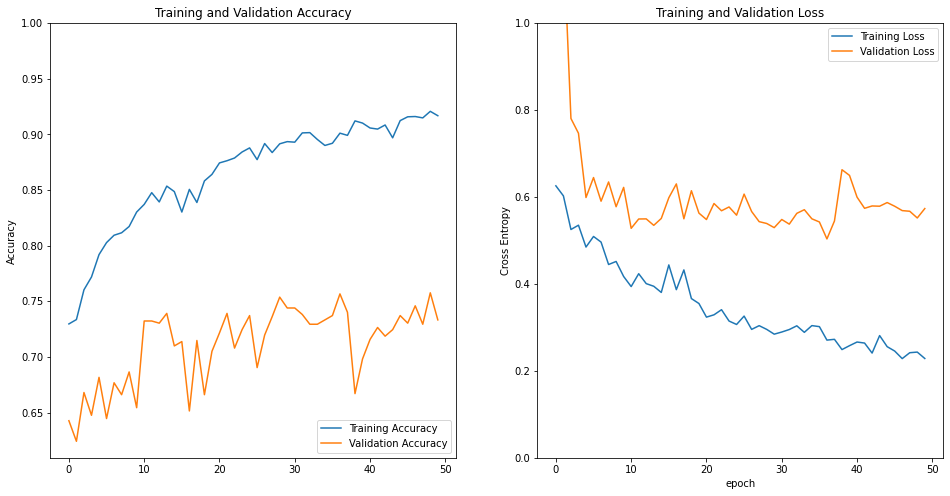

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 之前的結果

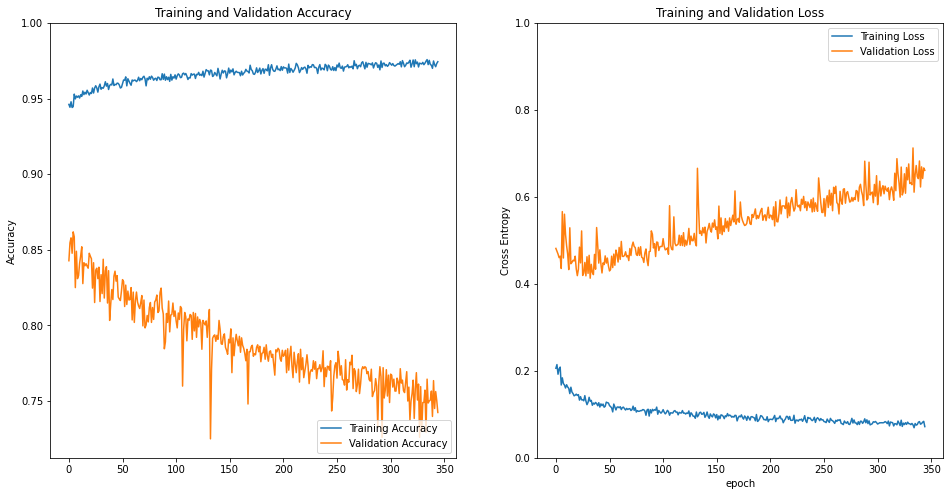

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

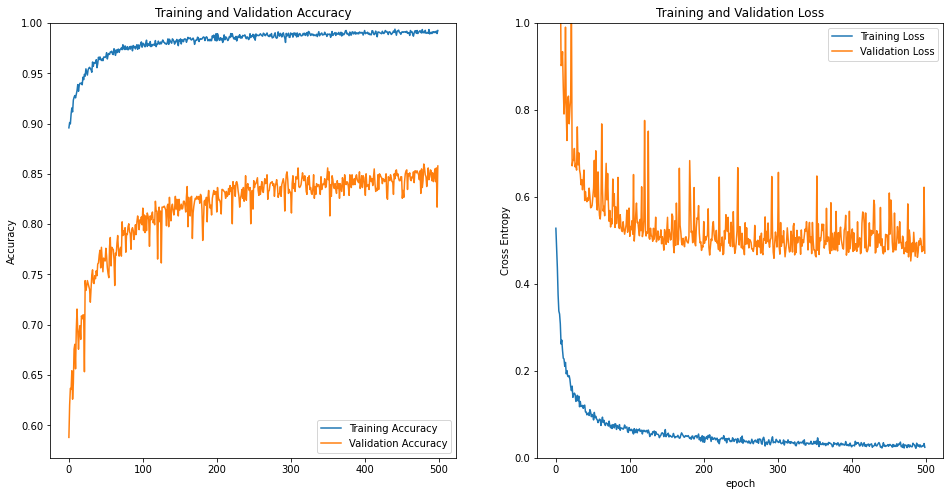

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 0821 訓練結果

In [14]:
# 參數設定
# seq = DataGenerator(df_trn2, '../data/folder_128/', batch_size=128)
# 模型訓練
history = tf_model.fit_generator(generator=seq_train, epochs=10, verbose=1, validation_data=seq_test,
                                 use_multiprocessing=False, workers=4)
# , use_multiprocessing=True, workers=4

Epoch 1/1000
95/95 [==============================] - 240s 3s/step - loss: 0.8943 - accuracy: 0.5177 - val_loss: 0.6642 - val_accuracy: 0.6191
Epoch 2/1000
95/95 [==============================] - 257s 3s/step - loss: 0.7868 - accuracy: 0.5290 - val_loss: 0.6675 - val_accuracy: 0.6191
Epoch 3/1000
95/95 [==============================] - 254s 3s/step - loss: 0.7223 - accuracy: 0.5521 - val_loss: 0.6654 - val_accuracy: 0.6191
Epoch 4/1000
95/95 [==============================] - 247s 3s/step - loss: 0.6947 - accuracy: 0.5718 - val_loss: 0.6651 - val_accuracy: 0.6191
Epoch 5/1000
95/95 [==============================] - 248s 3s/step - loss: 0.6805 - accuracy: 0.5892 - val_loss: 0.6659 - val_accuracy: 0.6191
Epoch 6/1000
95/95 [==============================] - 251s 3s/step - loss: 0.6750 - accuracy: 0.6000 - val_loss: 0.6648 - val_accuracy: 0.6191
Epoch 7/1000
95/95 [==============================] - 247s 3s/step - loss: 0.6725 - accuracy: 0.6086 - val_loss: 0.6670 - val_accuracy: 0.6191

Epoch 58/1000
95/95 [==============================] - 249s 3s/step - loss: 0.6509 - accuracy: 0.6299 - val_loss: 0.6864 - val_accuracy: 0.6191
Epoch 59/1000
95/95 [==============================] - 253s 3s/step - loss: 0.6513 - accuracy: 0.6277 - val_loss: 0.6824 - val_accuracy: 0.6191
Epoch 60/1000
95/95 [==============================] - 253s 3s/step - loss: 0.6494 - accuracy: 0.6300 - val_loss: 0.6856 - val_accuracy: 0.6194
Epoch 61/1000
95/95 [==============================] - 253s 3s/step - loss: 0.6500 - accuracy: 0.6275 - val_loss: 0.6849 - val_accuracy: 0.6197
Epoch 62/1000
95/95 [==============================] - 254s 3s/step - loss: 0.6493 - accuracy: 0.6315 - val_loss: 0.6796 - val_accuracy: 0.6197
Epoch 63/1000
95/95 [==============================] - 254s 3s/step - loss: 0.6490 - accuracy: 0.6259 - val_loss: 0.6693 - val_accuracy: 0.6194
Epoch 64/1000
95/95 [==============================] - 255s 3s/step - loss: 0.6496 - accuracy: 0.6310 - val_loss: 0.6783 - val_accuracy:

Epoch 115/1000
95/95 [==============================] - 254s 3s/step - loss: 0.6288 - accuracy: 0.6528 - val_loss: 0.6734 - val_accuracy: 0.6201
Epoch 116/1000
95/95 [==============================] - 251s 3s/step - loss: 0.6281 - accuracy: 0.6531 - val_loss: 0.6683 - val_accuracy: 0.6204
Epoch 117/1000
95/95 [==============================] - 266s 3s/step - loss: 0.6266 - accuracy: 0.6554 - val_loss: 0.6671 - val_accuracy: 0.6230
Epoch 118/1000
95/95 [==============================] - 256s 3s/step - loss: 0.6270 - accuracy: 0.6563 - val_loss: 0.6649 - val_accuracy: 0.6214
Epoch 119/1000
95/95 [==============================] - 256s 3s/step - loss: 0.6239 - accuracy: 0.6543 - val_loss: 0.6833 - val_accuracy: 0.6201
Epoch 120/1000
95/95 [==============================] - 258s 3s/step - loss: 0.6252 - accuracy: 0.6516 - val_loss: 0.6600 - val_accuracy: 0.6125
Epoch 121/1000
95/95 [==============================] - 253s 3s/step - loss: 0.6223 - accuracy: 0.6563 - val_loss: 0.6746 - val_ac

95/95 [==============================] - 253s 3s/step - loss: 0.4223 - accuracy: 0.8053 - val_loss: 0.7746 - val_accuracy: 0.6181
Epoch 228/1000
95/95 [==============================] - 253s 3s/step - loss: 0.4182 - accuracy: 0.8084 - val_loss: 0.7733 - val_accuracy: 0.5668
Epoch 229/1000
95/95 [==============================] - 253s 3s/step - loss: 0.4226 - accuracy: 0.8055 - val_loss: 0.7481 - val_accuracy: 0.5891
Epoch 230/1000
95/95 [==============================] - 257s 3s/step - loss: 0.4160 - accuracy: 0.8083 - val_loss: 0.7626 - val_accuracy: 0.6049
Epoch 231/1000
95/95 [==============================] - 260s 3s/step - loss: 0.4113 - accuracy: 0.8145 - val_loss: 0.7671 - val_accuracy: 0.5697
Epoch 232/1000
95/95 [==============================] - 261s 3s/step - loss: 0.4100 - accuracy: 0.8145 - val_loss: 0.7553 - val_accuracy: 0.6003
Epoch 233/1000
95/95 [==============================] - 257s 3s/step - loss: 0.4133 - accuracy: 0.8149 - val_loss: 0.7800 - val_accuracy: 0.6118


95/95 [==============================] - 220s 2s/step - loss: 0.1623 - accuracy: 0.9358 - val_loss: 1.0506 - val_accuracy: 0.5763
Epoch 340/1000
95/95 [==============================] - 215s 2s/step - loss: 0.1618 - accuracy: 0.9373 - val_loss: 1.0325 - val_accuracy: 0.6010
Epoch 341/1000
95/95 [==============================] - 214s 2s/step - loss: 0.1637 - accuracy: 0.9368 - val_loss: 1.1064 - val_accuracy: 0.5865
Epoch 342/1000
95/95 [==============================] - 218s 2s/step - loss: 0.1659 - accuracy: 0.9366 - val_loss: 1.0264 - val_accuracy: 0.6089
Epoch 343/1000
95/95 [==============================] - 221s 2s/step - loss: 0.1538 - accuracy: 0.9424 - val_loss: 1.0340 - val_accuracy: 0.6023
Epoch 344/1000
95/95 [==============================] - 225s 2s/step - loss: 0.1570 - accuracy: 0.9414 - val_loss: 1.1370 - val_accuracy: 0.5493
Epoch 345/1000
95/95 [==============================] - 225s 2s/step - loss: 0.1586 - accuracy: 0.9403 - val_loss: 1.0556 - val_accuracy: 0.5878


95/95 [==============================] - 225s 2s/step - loss: 0.0876 - accuracy: 0.9681 - val_loss: 1.2461 - val_accuracy: 0.6056
Epoch 452/1000
95/95 [==============================] - 223s 2s/step - loss: 0.0928 - accuracy: 0.9663 - val_loss: 1.3776 - val_accuracy: 0.5543
Epoch 453/1000
95/95 [==============================] - 218s 2s/step - loss: 0.0890 - accuracy: 0.9676 - val_loss: 1.2480 - val_accuracy: 0.5951
Epoch 454/1000
95/95 [==============================] - 216s 2s/step - loss: 0.0927 - accuracy: 0.9657 - val_loss: 1.2279 - val_accuracy: 0.5855
Epoch 455/1000
95/95 [==============================] - 215s 2s/step - loss: 0.0879 - accuracy: 0.9693 - val_loss: 1.2448 - val_accuracy: 0.5806
Epoch 456/1000
95/95 [==============================] - 219s 2s/step - loss: 0.0864 - accuracy: 0.9695 - val_loss: 1.2328 - val_accuracy: 0.5938
Epoch 457/1000
95/95 [==============================] - 220s 2s/step - loss: 0.0840 - accuracy: 0.9714 - val_loss: 1.2063 - val_accuracy: 0.6049


95/95 [==============================] - 222s 2s/step - loss: 0.0582 - accuracy: 0.9777 - val_loss: 1.3230 - val_accuracy: 0.5914
Epoch 564/1000
95/95 [==============================] - 228s 2s/step - loss: 0.0627 - accuracy: 0.9781 - val_loss: 1.3348 - val_accuracy: 0.5934
Epoch 565/1000
95/95 [==============================] - 222s 2s/step - loss: 0.0640 - accuracy: 0.9776 - val_loss: 1.3544 - val_accuracy: 0.5947
Epoch 566/1000
95/95 [==============================] - 219s 2s/step - loss: 0.0605 - accuracy: 0.9803 - val_loss: 1.3110 - val_accuracy: 0.5928
Epoch 567/1000
95/95 [==============================] - 213s 2s/step - loss: 0.0575 - accuracy: 0.9806 - val_loss: 1.4021 - val_accuracy: 0.6102
Epoch 568/1000
95/95 [==============================] - 213s 2s/step - loss: 0.0611 - accuracy: 0.9790 - val_loss: 1.4064 - val_accuracy: 0.5760
Epoch 569/1000
95/95 [==============================] - 217s 2s/step - loss: 0.0554 - accuracy: 0.9825 - val_loss: 1.3661 - val_accuracy: 0.6049


95/95 [==============================] - 219s 2s/step - loss: 0.0502 - accuracy: 0.9822 - val_loss: 1.4406 - val_accuracy: 0.5832
Epoch 676/1000
95/95 [==============================] - 220s 2s/step - loss: 0.0424 - accuracy: 0.9849 - val_loss: 1.4632 - val_accuracy: 0.5859
Epoch 677/1000
95/95 [==============================] - 220s 2s/step - loss: 0.0483 - accuracy: 0.9846 - val_loss: 1.3688 - val_accuracy: 0.5947
Epoch 678/1000
95/95 [==============================] - 222s 2s/step - loss: 0.0481 - accuracy: 0.9837 - val_loss: 1.5468 - val_accuracy: 0.5658
Epoch 679/1000
95/95 [==============================] - 219s 2s/step - loss: 0.0434 - accuracy: 0.9853 - val_loss: 1.3809 - val_accuracy: 0.5924
Epoch 680/1000
95/95 [==============================] - 215s 2s/step - loss: 0.0445 - accuracy: 0.9845 - val_loss: 1.4455 - val_accuracy: 0.5826
Epoch 681/1000
95/95 [==============================] - 215s 2s/step - loss: 0.0446 - accuracy: 0.9837 - val_loss: 1.4815 - val_accuracy: 0.5938


95/95 [==============================] - 220s 2s/step - loss: 0.0356 - accuracy: 0.9881 - val_loss: 1.4750 - val_accuracy: 0.6020
Epoch 788/1000
95/95 [==============================] - 219s 2s/step - loss: 0.0350 - accuracy: 0.9886 - val_loss: 1.4671 - val_accuracy: 0.5964
Epoch 789/1000
95/95 [==============================] - 219s 2s/step - loss: 0.0342 - accuracy: 0.9877 - val_loss: 1.5131 - val_accuracy: 0.5944
Epoch 790/1000
95/95 [==============================] - 220s 2s/step - loss: 0.0334 - accuracy: 0.9879 - val_loss: 1.4649 - val_accuracy: 0.6016
Epoch 791/1000
95/95 [==============================] - 222s 2s/step - loss: 0.0361 - accuracy: 0.9873 - val_loss: 1.5186 - val_accuracy: 0.5954
Epoch 792/1000
95/95 [==============================] - 222s 2s/step - loss: 0.0365 - accuracy: 0.9882 - val_loss: 1.4817 - val_accuracy: 0.5970
Epoch 793/1000
95/95 [==============================] - 220s 2s/step - loss: 0.0371 - accuracy: 0.9877 - val_loss: 1.4486 - val_accuracy: 0.6039


95/95 [==============================] - 223s 2s/step - loss: 0.0280 - accuracy: 0.9907 - val_loss: 1.5904 - val_accuracy: 0.5885
Epoch 900/1000
95/95 [==============================] - 220s 2s/step - loss: 0.0351 - accuracy: 0.9887 - val_loss: 1.5711 - val_accuracy: 0.5872
Epoch 901/1000
95/95 [==============================] - 221s 2s/step - loss: 0.0325 - accuracy: 0.9892 - val_loss: 1.5128 - val_accuracy: 0.5938
Epoch 902/1000
95/95 [==============================] - 221s 2s/step - loss: 0.0343 - accuracy: 0.9877 - val_loss: 1.6019 - val_accuracy: 0.5809
Epoch 903/1000
95/95 [==============================] - 222s 2s/step - loss: 0.0240 - accuracy: 0.9913 - val_loss: 1.5429 - val_accuracy: 0.6003
Epoch 904/1000
95/95 [==============================] - 221s 2s/step - loss: 0.0307 - accuracy: 0.9899 - val_loss: 1.5344 - val_accuracy: 0.5921
Epoch 905/1000
95/95 [==============================] - 219s 2s/step - loss: 0.0313 - accuracy: 0.9897 - val_loss: 1.5483 - val_accuracy: 0.5987


In [13]:
# print(df_trn[:8192].label.value_counts()[0]/8192)
# print(1 - df_trn[:8192].label.value_counts()[0]/8192)

0.69580078125
0.30419921875


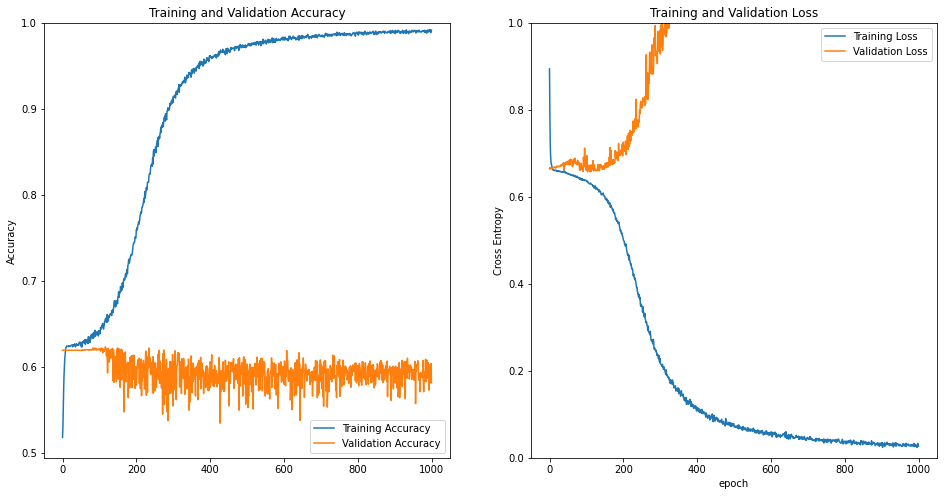

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 模型預測結果

In [20]:
prob_list_all = []
df = df_tmp
for i in range(len(df)):
    tmp = load_npz('../data/folder_128/' + df.GKF[i] + '/' + df.case[i] + '/' + df.final_key[i] + '.npz' )
    tmp = np.reshape(tmp, (1,128,128,64))
    score = tf_model.predict(tmp)[0][0]
    prob_list_all.append([df.GKF[i], df.case[i], df.final_key[i], df.label[i], score])
prob_list_all

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in short_scalars
  import sys


[['test', 'case', 'P1887_S01_R01_Y_S1', 'Y', 0.9996107],
 ['test', 'case', 'P1887_S01_R02_Y_S1', 'Y', 0.99974877],
 ['train', 'case', 'P2310_S01_R03_Y_S1', 'Y', 0.9883967],
 ['train', 'case', 'P2310_S01_R02_Y_S1', 'Y', 0.9961888],
 ['train', 'case', 'P2310_S01_R01_Y_S1', 'Y', 0.984746],
 ['train', 'case', 'P0662_S01_R01_Y_S1', 'Y', 0.9982022],
 ['train', 'case', 'P0662_S01_R02_Y_S1', 'Y', 0.9995353],
 ['train', 'case', 'P0662_S01_R03_Y_S1', 'Y', 0.994712],
 ['train', 'case', 'P1998_S01_R01_Y_S1', 'Y', 0.7538361],
 ['train', 'case', 'P1998_S01_R02_Y_S1', 'Y', 0.9867737],
 ['train', 'case', 'P1998_S01_R03_Y_S1', 'Y', 0.98051596],
 ['train', 'case', 'P1998_S01_R04_Y_S1', 'Y', 0.9952624],
 ['test', 'case', 'P1426_S01_R04_Y_S1', 'Y', 0.9930977],
 ['test', 'case', 'P1426_S01_R03_Y_S1', 'Y', 0.99683964],
 ['test', 'case', 'P1426_S01_R01_Y_S1', 'Y', 0.99864656],
 ['test', 'case', 'P1426_S01_R02_Y_S1', 'Y', 0.991835],
 ['test', 'case', 'P1451_S01_R03_Y_S1', 'Y', 0.3508356],
 ['test', 'case', 'P

In [43]:
df_score_all = pd.DataFrame(prob_list_all, columns=['GKF', 'case', 'final_key', 'label', 'score'])

In [44]:
df_score_all

,GKF,case,final_key,label,score
0,test,case,P1887_S01_R01_Y_S1,Y,0.999611
1,test,case,P1887_S01_R02_Y_S1,Y,0.999749
2,train,case,P2310_S01_R03_Y_S1,Y,0.988397
3,train,case,P2310_S01_R02_Y_S1,Y,0.996189
4,train,case,P2310_S01_R01_Y_S1,Y,0.984746
...,...,...,...,...,...
15120,train,control,P2506_S01_R02_N_S1,N,0.128032
15121,train,control,P2506_S01_R03_N_S1,N,0.114610
15122,train,control,P6075_S01_R02_N_S1,N,0.084404
15123,train,control,P6075_S01_R01_N_S1,N,0.071634


In [45]:
df_score_all['final_key'] = df_score_all.final_key.str.slice(0,15)
df_score_all

,GKF,case,final_key,label,score
0,test,case,P1887_S01_R01_Y,Y,0.999611
1,test,case,P1887_S01_R02_Y,Y,0.999749
2,train,case,P2310_S01_R03_Y,Y,0.988397
3,train,case,P2310_S01_R02_Y,Y,0.996189
4,train,case,P2310_S01_R01_Y,Y,0.984746
...,...,...,...,...,...
15120,train,control,P2506_S01_R02_N,N,0.128032
15121,train,control,P2506_S01_R03_N,N,0.114610
15122,train,control,P6075_S01_R02_N,N,0.084404
15123,train,control,P6075_S01_R01_N,N,0.071634


In [46]:
df_score_all.case.value_counts()

control    9425
case       5700
Name: case, dtype: int64

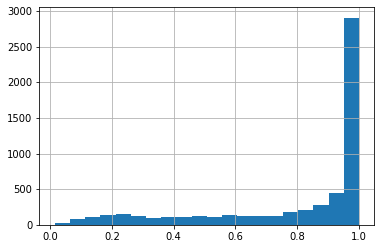

In [47]:
df_score_all.loc[df_score_all.label == 'Y', 'score'].hist(bins=20,)

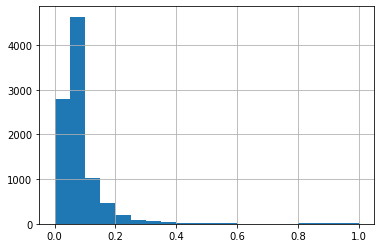

In [48]:
df_score_all.loc[df_score_all.label == 'N', 'score'].hist(bins=20)

In [49]:
y_score = df_score_all.loc[df_score_all.label == 'Y', 'score'].values
n_score = df_score_all.loc[df_score_all.label == 'N', 'score'].values

In [50]:
df_score_all.loc[[2250]]

,GKF,case,final_key,label,score
2250,test,case,P1193_S01_R01_Y,Y,0.998178


In [51]:
y_score.max(), y_score.min(), n_score.max(), n_score.min()

(1.0, 0.014799236319959164, 1.0, 0.0)

In [52]:
df_score_all.loc[(df_score_all.score < 0.01) & (df_score_all.label == 'Y'), :]

,GKF,case,final_key,label,score


In [53]:
df_score_all.loc[(df_score_all.score > 0.9) & (df_score_all.label == 'N'), :]

,GKF,case,final_key,label,score
5906,train,control,P2985_S01_R01_N,N,0.999629
5907,train,control,P2985_S01_R02_N,N,0.999998
6585,test,control,P3825_S01_R02_N,N,0.916957
6841,test,control,P4113_S01_R02_N,N,0.995666
7119,test,control,P5828_S01_R02_N,N,0.975306
7751,train,control,P4862_S01_R02_N,N,0.999193
8427,train,control,P4813_S01_R01_N,N,0.999968
9639,test,control,P5928_S01_R03_N,N,0.974523
9792,test,control,P3150_S01_R03_N,N,0.945306
10138,test,control,P5523_S01_R04_N,N,0.939833


In [54]:
df_score_all.loc[df_score_all.score == y_score.min(), :]

,GKF,case,final_key,label,score
4929,test,case,P1700_S01_R05_Y,Y,0.014799


In [55]:
np.mean(df_score_all.loc[df_score_all.label == 'Y', 'score'])

0.7963284193840401

In [56]:
np.mean(df_score_all.loc[df_score_all.label == 'N', 'score'])

0.08562636606331016

## 製作mapping表

In [57]:
df_mapping = pd.read_csv('../final_id_mapping.csv')
df_mapping

,final_key,PID,PID_STUDY,SID,RID,GKF,case,PATIENT_ID,study,series,length,study_date,acquisition_time,position
0,P1887_S01_R01_Y,psuedoID_1887,psuedoID_1887_S001,1,1,1,0,1.2.840.24652139151124160224891431703118616727...,1.2.840.25020658949133231411291332105612210813083,1.2.840.67424224310376501373210495162902461118,59,20180530,91127.20000,FFS
1,P1887_S01_R02_Y,psuedoID_1887,psuedoID_1887_S001,2,2,1,0,1.2.840.24652139151124160224891431703118616727...,1.2.840.25020658949133231411291332105612210813083,1.2.840.7416611515915281971941428914215165151210,59,20180530,91425.75000,FFS
2,P2310_S01_R03_Y,psuedoID_2310,psuedoID_2310_S001,1,3,5,0,1.2.840.13323514684248522824118117224824161262...,1.2.840.22811225363129249462006576542618423816157,1.2.840.8195253119492294721146136302056424841139,98,20180626,225032.60000,FFS
3,P2310_S01_R02_Y,psuedoID_2310,psuedoID_2310_S001,2,2,5,0,1.2.840.13323514684248522824118117224824161262...,1.2.840.22811225363129249462006576542618423816157,1.2.840.7593127191190846932323934079296189,98,20180626,224844.35000,FFS
4,P2310_S01_R01_Y,psuedoID_2310,psuedoID_2310_S001,3,1,5,0,1.2.840.13323514684248522824118117224824161262...,1.2.840.22811225363129249462006576542618423816157,1.2.840.23612919394279491611671392182411888177143,98,20180626,224653.35000,FFS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15120,P2506_S01_R02_N,psuedoID_2506,psuedoID_2506_S001,3,2,2,1,1.2.840.186167525423239133408514164261692043218,1.2.840.44134691771101210183498121517711110315...,1.2.840.90203721121012392361492302535048153512...,61,20181108,152951.15730,FFS
15121,P2506_S01_R03_N,psuedoID_2506,psuedoID_2506_S001,4,3,2,1,1.2.840.186167525423239133408514164261692043218,1.2.840.44134691771101210183498121517711110315...,1.2.840.132901788881377246719510812676189183161,61,20181108,152402.62640,FFS
15122,P6075_S01_R02_N,psuedoID_6075,psuedoID_6075_S001,1,2,4,1,1.2.840.2197295328252185151189221225130521006743,1.2.840.16865162199130204109961777696251106165100,1.2.840.78206176209594927531274918125073766152,83,20180129,93740.63264,HFS
15123,P6075_S01_R01_N,psuedoID_6075,psuedoID_6075_S001,2,1,4,1,1.2.840.2197295328252185151189221225130521006743,1.2.840.16865162199130204109961777696251106165100,1.2.840.71102212581032063221225123221219141101...,83,20180129,93421.26563,HFS


In [63]:
df_merge = pd.merge(df_score_all, df_mapping, how='inner', on=['final_key'])
df_merge

,GKF_x,case_x,final_key,label,score,PID,PID_STUDY,SID,RID,GKF_y,case_y,PATIENT_ID,study,series,length,study_date,acquisition_time,position
0,test,case,P1887_S01_R01_Y,Y,0.999611,psuedoID_1887,psuedoID_1887_S001,1,1,1,0,1.2.840.24652139151124160224891431703118616727...,1.2.840.25020658949133231411291332105612210813083,1.2.840.67424224310376501373210495162902461118,59,20180530,91127.20000,FFS
1,test,case,P1887_S01_R02_Y,Y,0.999749,psuedoID_1887,psuedoID_1887_S001,2,2,1,0,1.2.840.24652139151124160224891431703118616727...,1.2.840.25020658949133231411291332105612210813083,1.2.840.7416611515915281971941428914215165151210,59,20180530,91425.75000,FFS
2,train,case,P2310_S01_R03_Y,Y,0.988397,psuedoID_2310,psuedoID_2310_S001,1,3,5,0,1.2.840.13323514684248522824118117224824161262...,1.2.840.22811225363129249462006576542618423816157,1.2.840.8195253119492294721146136302056424841139,98,20180626,225032.60000,FFS
3,train,case,P2310_S01_R02_Y,Y,0.996189,psuedoID_2310,psuedoID_2310_S001,2,2,5,0,1.2.840.13323514684248522824118117224824161262...,1.2.840.22811225363129249462006576542618423816157,1.2.840.7593127191190846932323934079296189,98,20180626,224844.35000,FFS
4,train,case,P2310_S01_R01_Y,Y,0.984746,psuedoID_2310,psuedoID_2310_S001,3,1,5,0,1.2.840.13323514684248522824118117224824161262...,1.2.840.22811225363129249462006576542618423816157,1.2.840.23612919394279491611671392182411888177143,98,20180626,224653.35000,FFS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15120,train,control,P2506_S01_R02_N,N,0.128032,psuedoID_2506,psuedoID_2506_S001,3,2,2,1,1.2.840.186167525423239133408514164261692043218,1.2.840.44134691771101210183498121517711110315...,1.2.840.90203721121012392361492302535048153512...,61,20181108,152951.15730,FFS
15121,train,control,P2506_S01_R03_N,N,0.114610,psuedoID_2506,psuedoID_2506_S001,4,3,2,1,1.2.840.186167525423239133408514164261692043218,1.2.840.44134691771101210183498121517711110315...,1.2.840.132901788881377246719510812676189183161,61,20181108,152402.62640,FFS
15122,train,control,P6075_S01_R02_N,N,0.084404,psuedoID_6075,psuedoID_6075_S001,1,2,4,1,1.2.840.2197295328252185151189221225130521006743,1.2.840.16865162199130204109961777696251106165100,1.2.840.78206176209594927531274918125073766152,83,20180129,93740.63264,HFS
15123,train,control,P6075_S01_R01_N,N,0.071634,psuedoID_6075,psuedoID_6075_S001,2,1,4,1,1.2.840.2197295328252185151189221225130521006743,1.2.840.16865162199130204109961777696251106165100,1.2.840.71102212581032063221225123221219141101...,83,20180129,93421.26563,HFS


In [64]:
features = ['GKF_y', 'GKF_x', 'case_x', 'final_key', 'label', 'score',  'length', 'study_date', 'position']

In [67]:
df_merge = df_merge[features]
df_merge

,GKF_y,GKF_x,case_x,final_key,label,score,length,study_date,position
0,1,test,case,P1887_S01_R01_Y,Y,0.999611,59,20180530,FFS
1,1,test,case,P1887_S01_R02_Y,Y,0.999749,59,20180530,FFS
2,5,train,case,P2310_S01_R03_Y,Y,0.988397,98,20180626,FFS
3,5,train,case,P2310_S01_R02_Y,Y,0.996189,98,20180626,FFS
4,5,train,case,P2310_S01_R01_Y,Y,0.984746,98,20180626,FFS
...,...,...,...,...,...,...,...,...,...
15120,2,train,control,P2506_S01_R02_N,N,0.128032,61,20181108,FFS
15121,2,train,control,P2506_S01_R03_N,N,0.114610,61,20181108,FFS
15122,4,train,control,P6075_S01_R02_N,N,0.084404,83,20180129,HFS
15123,4,train,control,P6075_S01_R01_N,N,0.071634,83,20180129,HFS


In [69]:
df_merge.columns = ['KF', 'GKF', 'case', 'final_key', 'label', 'score', 'length', 'study_date','position']
df_merge

,KF,GKF,case,final_key,label,score,length,study_date,position
0,1,test,case,P1887_S01_R01_Y,Y,0.999611,59,20180530,FFS
1,1,test,case,P1887_S01_R02_Y,Y,0.999749,59,20180530,FFS
2,5,train,case,P2310_S01_R03_Y,Y,0.988397,98,20180626,FFS
3,5,train,case,P2310_S01_R02_Y,Y,0.996189,98,20180626,FFS
4,5,train,case,P2310_S01_R01_Y,Y,0.984746,98,20180626,FFS
...,...,...,...,...,...,...,...,...,...
15120,2,train,control,P2506_S01_R02_N,N,0.128032,61,20181108,FFS
15121,2,train,control,P2506_S01_R03_N,N,0.114610,61,20181108,FFS
15122,4,train,control,P6075_S01_R02_N,N,0.084404,83,20180129,HFS
15123,4,train,control,P6075_S01_R01_N,N,0.071634,83,20180129,HFS


## 資料儲存

In [70]:
df_merge.to_csv('./df_score_model2_last35_0929.csv', index=False)

In [71]:
pd.read_csv('./df_score_model2_last35_0929.csv')

,KF,GKF,case,final_key,label,score,length,study_date,position
0,1,test,case,P1887_S01_R01_Y,Y,0.999611,59,20180530,FFS
1,1,test,case,P1887_S01_R02_Y,Y,0.999749,59,20180530,FFS
2,5,train,case,P2310_S01_R03_Y,Y,0.988397,98,20180626,FFS
3,5,train,case,P2310_S01_R02_Y,Y,0.996189,98,20180626,FFS
4,5,train,case,P2310_S01_R01_Y,Y,0.984746,98,20180626,FFS
...,...,...,...,...,...,...,...,...,...
15120,2,train,control,P2506_S01_R02_N,N,0.128032,61,20181108,FFS
15121,2,train,control,P2506_S01_R03_N,N,0.114610,61,20181108,FFS
15122,4,train,control,P6075_S01_R02_N,N,0.084404,83,20180129,HFS
15123,4,train,control,P6075_S01_R01_N,N,0.071634,83,20180129,HFS
